In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# Nearest Neighbors Regression 🏘

Name: Soohoon Oh

Contact: soohoonoh@wustl.edu

Sources : from Washu CSE217a course materials


## 1. Using `sklearn` for $k$-Nearest Neighbors

In Lab 8, we got familiar with $k$-nearest neighbors ($k$-NN) by implementing the algorithm. If you are still not comfortable with how the algorithm works, then we suggest that you review your work from the lab. In this home work, we will proceed under the assumption that you are familiar with $k$-NN.

In this section, we will explore how to use the [$k$-NN _regression_ model supplied by `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor). You can find the [$k$-NN _classification_ model here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

### Loading and Preparing the Data

We'll need to start by getting some data — what is data science without data? For this assignment, we will be revisiting another old friend: the Boston Housing dataset.

In [2]:
from sklearn.datasets import load_boston

boston = load_boston()
X_all, y = boston.data, boston.target

While we're here, let's review what this dataset is about.

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

<!-- BEGIN QUESTION -->

### Problem 1.1

**Write-up!** How many examples are in the dataset? How many features does it have? What are the features? What is the target variable that we would like to estimate/predict? What kind of machine learning problem is this?

There are 506 examples and 14 features. The features are CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT, MEDV. 
The target we want to estimate is the price of houses in Boston. This is the regression problem. 

<!-- END QUESTION -->

Based on our discussions in `Lab4` and `hw4`, we will include all data points and all features but _1000(Bk - 0.63)^2_ where _Bk_ is the proportion of blacks by town encoded as `'B'`. 

In [4]:
# remove 'B' feature
features_to_use = boston.feature_names!='B'
X = X_all[:, features_to_use]

### Scaling Data

In the lab, we also looked at data scaling and transformations. Here we'll demonstrate how to use `sklearn` to help us with this.

**Approach 1:** 

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# new train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# compute the mean and standard deviation on a training set 
scaler = preprocessing.StandardScaler().fit(X_train)

# apply the transforamtion to both the trainnig and the test set
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

**Approach 2:** 
An alternative and much quicker way of scaling the the data is the following.

In [6]:
X_scaled = preprocessing.scale(X)

<!-- BEGIN QUESTION -->

### Problem 1.2

**Write-up** What types of scaling does `StandardScaler()` and `scale` perform? Which of the two procedures is a more appropriate preprocessing step for supervised machine learning and _why_? 
> **Hint:** Use the [`?` operator](https://ipython.readthedocs.io/en/stable/interactive/python-ipython-diff.html#accessing-help) to get more information about the two scaling methods. 

Both methods implement standardization. But we should use Standardscaler() because it divided data into X_test and X_train while scale do scaling with the entire data. If the scale is implemented with the entire data, the mean value changes from the mean of the train data which can lead to incorrect prediction model.

<!-- END QUESTION -->

### Looking Into the Model

Now that we have some data to play with, let's try building a $k$-NN regression model. The model provided by `sklearn` shares a similar interface with the other models that we have looked at previously (especially $k$-means).

In [7]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=3)

### Problem 1.3

Use the [`?` operator](https://ipython.readthedocs.io/en/stable/interactive/python-ipython-diff.html#accessing-help) provided by IPython to explore `model` and it's interface.

**Do this!** In the cell below, complete the following:
1. create and fit a new `KNeighborsRegressor` model with 5 neighbors.
2. make some predictions using the model on your testing data.
3. evaluate the performance of the model by computing $R^2$ and storing it in `r_squared`.

In [8]:
model?

In [9]:
import numpy as np

new_model = KNeighborsRegressor(n_neighbors=5)

new_model = new_model.fit(X_train, y_train)

y_hat = new_model.predict(X_test)

r_squared = r2 = 1 - ((np.square(y_test - y_hat).mean()) / np.var(y_test))

r_squared

0.7051364300656733

In [10]:
grader.check("q1c")

q1c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Problem 1.4

**Write-up!** What was the $R^2$ value for your k-NN model using five neighbors? What does $R^2$ tell you about a model? What does this particular score tell you about your k-NN model?

<!-- END QUESTION -->

With that, let's move on to some more interesting things.

## 2. Choosing $k$ with Cross Validation

In order to test whether the `k-NN` algorithm (or any other machine learning algorithm) performs how we want it to and accurately makes predictions, we must compare the known label of all datapoints to the predicted label of those same datapoints. So far we have seen this in the forms of model evaluation and validation in model selection. 

In model evaluation we partitioned our original dataset into two parts: a training set and a testing set. As we have seen earlier in the course, the testing set is a smaller percentage of the total dataset than the training set.

Later on, in model selection, we explored why it was important to have yet another set of data partitioned out for usage as a validation set, which we could use to experiment with a model's hyperparameters (value that is used to control the learning process). The validation set allowed us to "evaluate" our model's performance with various settings of its parameters while maintaining a completely untouched dataset for out final evaluation.

We can extend this idea once again to improve our estimates of model performance using **cross validation**.

> **CAUTION:** It is a total coincidence that for cross-valiation the number of partitions, also called folds, are typically numbered with the variable _k_. 

> **This** k **as in "k-fold cross-validataion" has nothing to do with the** k **in k-NN!**

### `kFolds` method

One version of cross validation partitions the dataset into `k` partitions, or folds. We use `k-1` folds to train the model and one fold (fold we left out) to test the model. We iterate this process `k` times, leaving out a different fold each time, so that we have an accuracy score for each one of the `k` different partitions. We can then take the average of all of these accuracies to calculate a more wholistic accuracy representation of the algorithm. In the example below, `k = 5`; there are 5 partitions. Each partition is used once as a test partition while the other 4 are used for training purposes. The idea for $k$-fold cross validation is based on the realization that we can get a better picture of our model's performance by feeding it different combinations of our data.

![](utility/pics/kFold.png)

We use the [`KFold`🔗](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function from `sklearn`to partition our dataset into `n_splits` partitions. While the `KFold` function does not split the dataset itself, it provides the **indices** on which to split the dataset.

Below, we split an random array of length 10 into 5 folds:

In [11]:
from sklearn.model_selection import KFold

dummy = np.random.randint(10, 100, size = 10) # example data
print(f'data: {dummy}')

# initialize KFolds
kf = KFold(n_splits=5, shuffle=True)

# iterating over k different splits of dummy
for fold, (train_idx, test_idx) in enumerate(kf.split(dummy)):
    print(f'For iteration {fold}: Train indices: {train_idx}. Test indices: {test_idx}')

data: [70 60 73 78 99 72 83 15 60 55]
For iteration 0: Train indices: [1 2 3 4 5 7 8 9]. Test indices: [0 6]
For iteration 1: Train indices: [0 1 2 3 6 7 8 9]. Test indices: [4 5]
For iteration 2: Train indices: [0 2 3 4 5 6 7 8]. Test indices: [1 9]
For iteration 3: Train indices: [0 1 2 4 5 6 7 9]. Test indices: [3 8]
For iteration 4: Train indices: [0 1 3 4 5 6 8 9]. Test indices: [2 7]


Notice how each testing datapoint appears once, ensuring that all datapoints have had a chance to be be tested against the model trained with the rest of the dataset. 

### Problem 2.1

Now, let's use the `KFold` operation on the full Boston Housing dataset.

**Do this!** Complete the `knn_kfolds` function so that it performs `n_folds`-fold cross validation on the dataset `X` and applies $k$-NN regression with k=`n_neighbors` nearest neighbors. The function should return the average $R^2$ value of the model across the folds as `avg_score`.

* Make sure to **scale** your training and test sets appropriately (à la the [Scaling Data](#Scaling-Data) section).
* Ensure that you make and **fit a new model** for each fold.
* Also, please make sure that you set `random_state` appropriately in your initialization of `KFold`.

>**Hint**: Refer to the previous example of how to use `KFold` and your work in [Problem 1.2](#Problem-1.2).

In [12]:
def knn_kfolds(X, y, n_folds, n_neighbors, random_state=None):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state = random_state)
    r2scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train) 
        X_test = scaler.transform(X_test) 
        
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
        model.fit(X_train, y_train)
        r_squared = model.score(X_test, y_test)
        
        r2scores.append(r_squared)
        
    avg_score = np.mean(r2scores)
    return avg_score

In [13]:
grader.check("q2a")

q2a results: All test cases passed!

In [14]:
knn_kfolds(X, y, 5, 3, random_state=10)

0.7652077509624957

### Choosing $k$

We can use cross validation as a substitute for the model selection algorithm that we've used in the past.

<!-- BEGIN QUESTION -->

### Problem 2.2

In this problem, we will use cross validation and our `knn_kfolds` function to help us pick the right $k$ to use for our Boston Housing predictions.

**Do this!** In the following cell, use `knn_kfolds()` to preform 10-fold cross validation on `X` and `y` to evaluate the performance of $k$-NN on the Boston Housing dataset and provide a plot of the cross validation average $R^2$ values for neares neighbor values `k` from 1 to 20 (inclusive). Use a `random_state` of 12 for your analysis. Ensure that your plot has all of the appropriate components.

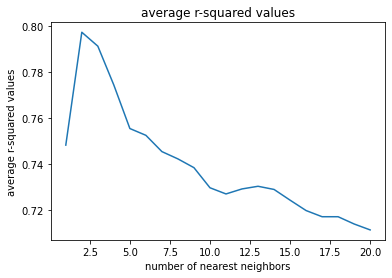

In [15]:
import matplotlib.pyplot as plt

k = range(1, 21)
avg_arr = []

for j in k:
    avg_r2score = knn_kfolds(X, y, 10, j, random_state=12)
    avg_arr.append(avg_r2score)

plt.title('average r-squared values')
plt.xlabel("number of nearest neighbors")
plt.ylabel('average r-squared values')
plt.plot(k, avg_arr)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Problem 2.3

**Write-up!** Based on your plot from [Problem 2.2](#Problem-2.2), which $k$ value would you pick for your final model? Explain why.

I would pick 2 for k because it showed the highest average R-squared score. It means the model with 2 neighbors would show the best fit.

<!-- END QUESTION -->

## 3. Model Comparison with Cross Validation

As mentioned before, we can use cross validation to get a more thorough evaluation of model performance. Now, we will use CV for model comparison by substituting it in for the model selection process that we have used in above. Note that the approach below is actually not quite legal, since we already used all our data in kNN to select k in **Problem 2.2** and now we are using the _same_ data again to preform model comparison. 

In this section, we will compare our $k$-NN regression model with a linear regression model that we used back in `Lab4` when we last looked at the Boston Housing dataset.

### Problem 3.1

**Do this!** In the following cell, report the cross validation score (average $R^2$) of a $k$-NN model with the $k$ you selected in [Problem 2.3](#Problem-2.3) on `X_scaled`. Use a `random_state` of 5.

In [16]:
cross_val_score = knn_kfolds(X_scaled, y, 10, 2, random_state=5)
print(cross_val_score)

0.799568165440979


<!-- BEGIN QUESTION -->

### Problem 3.2

Now let's do 10-fold cross validation on a linear regression model on `X` without scaling.

**Write-up** Why should shouldn't we use scaling here? What will happen if we do?

In the linear regression problem, we get the same model from the same data regardless of wheter we scale the data or not. thus we don't need scaling and moreover, if we scale the data, all the units of data becomes 0 to 1 so the interpretability is also reduced. 
Therefore, we should not scale the data and directly use the data. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Do this!** Perform 10-fold cross validation for linear regression on `X` and report the average $R^2$ value across all of the folds.

* Ensure that you make and **fit a new model** for each fold.
* Use the same random state as we used to evaluate k-NN, so that the cross-validation splits stay the **same**. 

> **Hint:** Refer to your work in [Problem 2.1](#Problem-2.1) and [Problem 3.1](#Problem-3.1).

In [17]:
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=10, shuffle=True, random_state = 5)
r2_scores = []
    
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X__train, X__test, y__train, y__test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    
    model = LinearRegression()
    model.fit(X__train, y__train)
    r__squared = model.score(X__test, y__test)
    
    r2_scores.append(r__squared)
        
avg__score = np.mean(r2_scores)

avg__score

0.7127233828193871

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Problem 3.3

**Write-up!** What were the $R^2$ values for each of the models? Which model would you prefer? Why?

R-squared value of k-NN model is 0.799568165440979 and that of linear regression model is 0.7127233828193871. I would choose k-NN model as it has larger R-squared value. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Problem 3.4

**Write-up!** What are your next steps as a data scientist now that you have decided which model to use? Describe two things (related to the DS workflow of this project). Did you notice any thing in our workflow above that was

After I decide the model, I will evaluate the model, by comparing with the ground truth. Then I would communicate the results from the solution.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Write-up!** Did you notice any thing in our workflow above that was not quite right? If so share your critical review with your boss (well for now, with us). Thanks!

One concern I found was that we used the transformed dataset, X_scaled, which is made by preprocessing.scale() function with the entire data. We should rather scale the data based on only the part of the dataset, which we defined to be train data. 

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [18]:
grader.check_all()

q1c results: All test cases passed!

q2a results: All test cases passed!

q3a results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [19]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)